## Ising Model - Artem Stopnevich

- Abstract
- Introduction
- Body
    - Theory
    - Model Implementation
- Conclusion

In [4]:
%load_ext Cython

In [6]:
%%cython

from numpy.random import rand
cimport cython
import cython
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from libc.math cimport sqrt, exp #raw c funcs
cdef extern from "limits.h":
    int RAND_MAX # specifiying max random number 

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef class Ising():
    cdef int N, eqSteps, mcSteps, nt
    def __init__(self, N, nt, eqSteps, mcSteps):
        self.N      = N 
        self.nt     = nt
        self.eqSteps = eqSteps
        self.mcSteps = mcSteps  

    cpdef twoD(self, np.int64_t[:, :] Field, double [:] E, double [:] M, double [:] C, double [:] X, double [:] B, double [:] Error_E, double [:] Error_M):
        cdef int eqSteps = self.eqSteps, mcSteps = self.mcSteps, N = self.N, nt = self.nt
        cdef double E1, M1, E2, M2, beta,  Ene, Mag
        cdef int i, tt, N2 = N*N
        cdef double iMCS = 1.0/mcSteps, iNs = 1.0/N2
        for tt in range(nt):
            print(tt, nt)
            ene_array = mag_array = np.zeros((mcSteps), dtype=np.float64)
            E1 = E2 = M1 = M2= 0
            Mag = 0
            beta = B[tt]
            initialise(Field, N)

            for i in range(eqSteps):
                ising_step(Field, beta, N)

            for i in range(mcSteps):
                ising_step(Field, beta, N)

                Ene = calcEnergy(Field, N)
                Mag = calcMag(Field,N)
                E1 = E1 + Ene
                ene_array[i] = Ene
                M1 = M1 + Mag
                mag_array[i] = Mag
                E2 = E2 + Ene*Ene
                M2 = M2 + Mag*Mag

            E[tt] = E1*iMCS*iNs 
            M[tt] = M1*iMCS*iNs 
            C[tt] = (E2*iMCS - E1*E1*iMCS*iMCS)*beta*beta*iNs;
            X[tt] = (M2*iMCS - M1*M1*iMCS*iMCS)*beta*iNs;
#            Q[tt] = (M2*iMCS)/(abs(M1)*iMCS)**2;
            Error_E[tt] = blocking_error(ene_array, 10)
            Error_M[tt] = blocking_error(mag_array, 10)
        return 

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef initialise(np.int64_t[:,:] Field, int N):    # generates a random spin Spin configuration
    '''generates a random spin configuration for initial condition'''
    cdef int i, j
    for i in range(1, N+1):
        for j in range(1, N+1):
            if rand() < 0.5: 
                Field[i, j]=-1
            else:
                Field[i, j]=1
    return 0 

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cpdef ising_step(np.int64_t[:, :] Field, float beta, int N):
    cdef int ii, a, b
    for ii in range(N*N):
        a = np.random.randint(0,N)
        b = np.random.randint(0,N)
        Field[0, b]   = Field[N, b];  Field[N+1, b] = Field[1, b];  # ensuring BC
        Field[a, 0]   = Field[a, N];  Field[a, N+1] = Field[a, 1];
        
        dE = 2*Field[a, b]*(Field[a+1, b] + Field[a, b+1] + Field[a-1, b] + Field[a, b-1])
        if dE < 0:          #have a look at C replacement
            Field[a,b] *= -1
        elif rand() < exp(-dE*beta):
            Field[a,b] *= -1
    return 0

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef int calcEnergy(np.int64_t[:, :] Field, int N):
    ''' Energy calculation'''
    cdef int i, j, energy = 0
    for i in range(1, N+1):
        for j in range(1, N+1):
            Field[0, j] = Field[N, j];  Field[i, 0] = Field[i, N];
            energy += -Field[i, j] * (Field[i-1, j] + Field[i, j-1]) 
    return energy

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef int calcMag(np.int64_t[:,:] Field, int N):
    '''Magnetization of a given configuration'''
    cdef int i, j, mag = 0
    for i in range(1,N+1):
        for j in range(1,N+1):
            mag += Field[i,j]
    return mag   

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef float blocking_error(double [:] A, int num_blocks):
    mean_values = np.zeros(num_blocks)
    error_block = np.zeros(num_blocks)
    itemize = range(1, num_blocks+1)
    blocks = np.array_split(A, num_blocks)
    cdef  error, global_mean = np.mean(A)
    cdef int i
    for i in range(num_blocks):
        mean_values[i] = np.mean(blocks[i])
        error_block = sqrt((1/itemize[i]) * np.sum((mean_values - global_mean)**2))
    error = error_block/sqrt(num_blocks)

    return error

## Two Dimensional Ising

In [7]:
##############################################################################
# SIMULATION
##############################################################################
N = 16
nt = 30
eqSteps = 1000
mcSteps = 1000

Field           = np.zeros((N+2,N+2), dtype=np.int64)
Energy          = np.zeros((nt), dtype=np.float64)
Magnetization   = np.zeros((nt), dtype=np.float64)
SpecificHeat    = np.zeros((nt), dtype=np.float64)
Susceptibility  = np.zeros((nt), dtype=np.float64)
Error_Ene       = np.zeros((nt), dtype=np.float64)
Error_Mag       = np.zeros((nt), dtype=np.float64)

#Temperature
Temperature = np.linspace(0.5,3.5, nt)
Beta = 1.0/Temperature   # set k_B = 1

Ising = Ising(N, nt, eqSteps, mcSteps)

Ising.twoD(Field, Energy, Magnetization, SpecificHeat, Susceptibility, Beta, Error_Ene, Error_Mag)


0 30
1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30


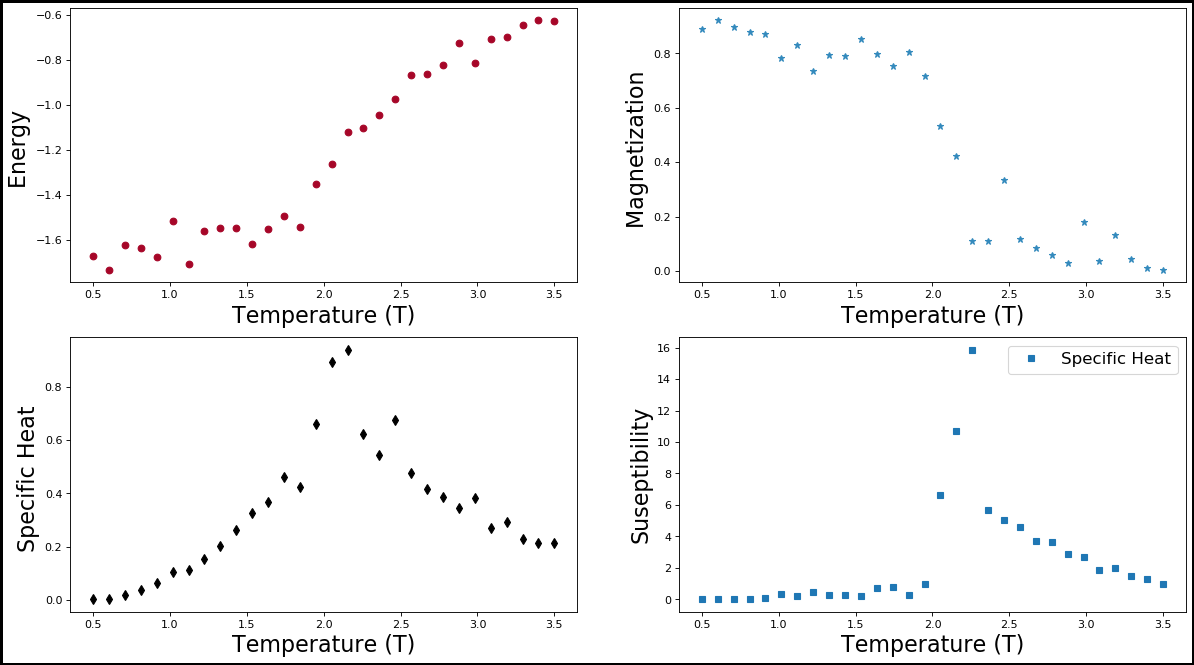

In [8]:
##############################################################################
# VISUALIZATION
##############################################################################
f = plt.figure(figsize=(18, 10), dpi=80, linewidth=3, facecolor='w', edgecolor='k');    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(Temperature, Energy, 'o', color="#A60628", label=' Energy');
#plt.errorbar(Temperature, Energy, fmt='none', xerr=0, yerr= Error_Ene);
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);

sp =  f.add_subplot(2, 2, 2 );
plt.plot(Temperature, abs(Magnetization), '*', color="#348ABD", label='Magnetization');
#plt.errorbar(Temperature, abs(Magnetization), fmt='none', xerr=0, yerr= Error_Mag)
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);


sp =  f.add_subplot(2, 2, 3 );
plt.plot(Temperature, SpecificHeat, 'd', color='black', label='Specific Heat');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);


sp =  f.add_subplot(2, 2, 4 );
plt.plot(Temperature, Susceptibility, 's', label='Specific Heat');
plt.legend(loc='best', fontsize=15); 
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Suseptibility", fontsize=20);


plt.show()

## Binder Ratios

0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 20
15 20
16 20
17 20
18 20
19 20
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 20
15 20
16 20
17 20
18 20
19 20


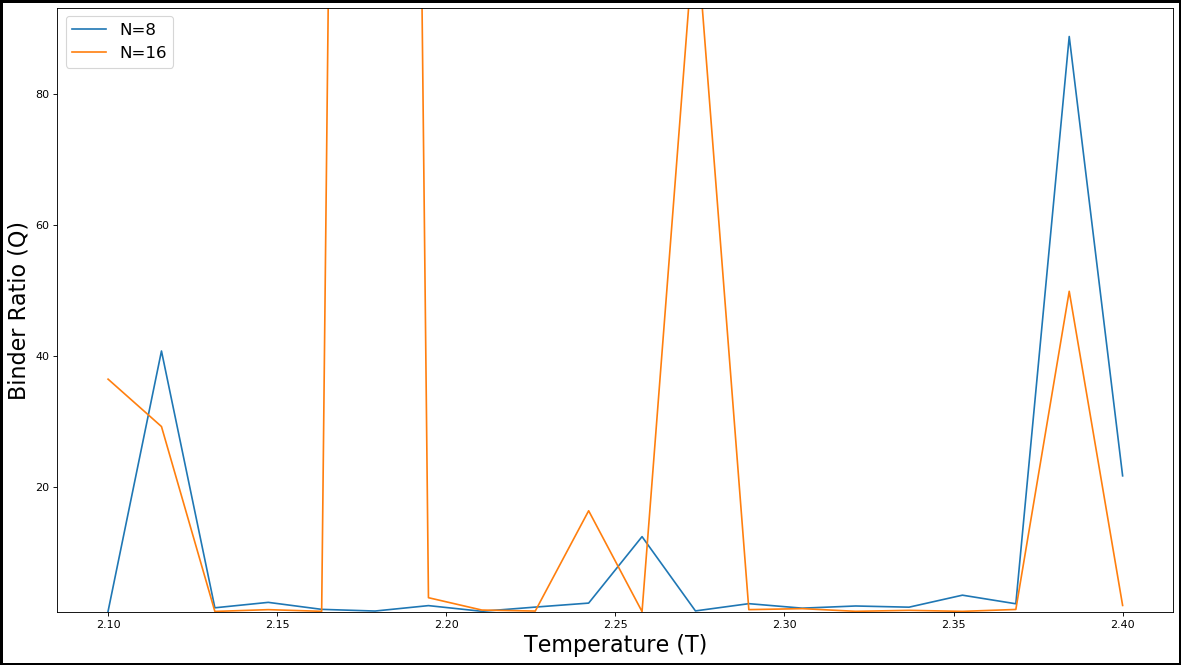

In [16]:
f = plt.figure(figsize=(18, 10), dpi=80, linewidth=3, facecolor='w', edgecolor='k');    
for i in [8,16]:
    N, nt       = i, 20
    eqSteps, mcSteps = 1000, 1000

    Field           = np.zeros((N+2,N+2), dtype=np.int64)
    Energy          = np.zeros((nt), dtype=np.float64)
    Magnetization   = np.zeros((nt), dtype=np.float64)
    SpecificHeat    = np.zeros((nt), dtype=np.float64)
    Susceptibility  = np.zeros((nt), dtype=np.float64)
    Error_Ene       = np.zeros((nt), dtype=np.float64)
    Error_Mag       = np.zeros((nt), dtype=np.float64)
    Binder          = np.zeros((nt), dtype=np.float64)
    #Temperature
    Temperature = np.linspace(2.1,2.4, nt)
    Beta = 1.0/Temperature   # set k_B = 1
    
    #instantiate the class Ising model
    ising = Ising(N, nt, eqSteps, mcSteps)

    ising.twoD(Field, Energy, Magnetization, SpecificHeat, Susceptibility, Beta, Error_Ene, Error_Mag, Binder)

    #sp =  f.add_subplot(2, 2, (i+1) ); 
    ## Finite size scaling of suseptibility: chi(L) = chi*L^(-\gamma/nu)
#   plt.plot(Temperature, Susceptibility*N**(-7.0/4.0), label='N=%s'%N);
    plt.plot(Temperature, Binder, label='N=%s'%N)
    plt.legend(loc='best', fontsize=15); 
    plt.ylim(bottom = 1)
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Binder Ratio (Q)", fontsize=20);


plt.show()

## Cluster Algorithm

In [1]:
import random, math

L = 20
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
                                    for i in range(N)}
T = 2.5
p  = 1.0 - math.exp(-2.0 / T)
nsteps = 10000
S = [random.choice([1, -1]) for k in range(N)]
for step in range(nsteps):
    k = random.randint(0, N - 1)
    Pocket, Cluster = [k], [k]
    while Pocket != []:
        j = random.choice(Pocket)
        for l in nbr[j]:
            if S[l] == S[j] and l not in Cluster \
                   and random.uniform(0.0, 1.0) < p:
                Pocket.append(l)
                Cluster.append(l)
        Pocket.remove(j)
    for j in Cluster:
        S[j] *= -1

